In [1]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
import time
import numpy as np

In [2]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Dataset path
data_dir = '/kaggle/input/multi-class-driver-behavior-image-dataset/Multi-Class Driver Behavior Image Dataset'


In [4]:
# Enhanced transforms for better training
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_val_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = datasets.ImageFolder(data_dir, transform=transform_val_test)
num_classes = len(full_dataset.classes)
print("Classes:", full_dataset.classes)
print(f"Total images: {len(full_dataset)}")
print(f"Number of classes: {num_classes}")

# Split into train (80%), val (10%), test (10%)
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size
train_data, val_data, test_data = random_split(full_dataset, [train_size, val_size, test_size])


Classes: ['other_activities', 'safe_driving', 'talking_phone', 'texting_phone', 'turning']
Total images: 7276
Number of classes: 5


In [5]:
# Apply training transforms to training data
train_data.dataset = datasets.ImageFolder(data_dir, transform=transform_train)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_data)}, Val samples: {len(val_data)}, Test samples: {len(test_data)}")



Train samples: 5820, Val samples: 727, Test samples: 729


 Loading ResNet50 model...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total parameters: 23,518,277
Trainable parameters: 23,518,277
Starting training...

Epoch 1/25
Learning Rate: 0.000100
  Batch 0/182, Loss: 1.6508
  Batch 50/182, Loss: 0.6982
  Batch 100/182, Loss: 0.5854
  Batch 150/182, Loss: 0.4926
Train Loss: 0.7286, Train Acc: 83.33%
Val Loss: 0.5093, Val Acc: 94.77%
✓ New best validation accuracy: 94.77%

Epoch 2/25
Learning Rate: 0.000100
  Batch 0/182, Loss: 0.6308
  Batch 50/182, Loss: 0.4780
  Batch 100/182, Loss: 0.5428
  Batch 150/182, Loss: 0.5061
Train Loss: 0.5343, Train Acc: 94.00%
Val Loss: 0.5113, Val Acc: 94.77%

Epoch 3/25
Learning Rate: 0.000098
  Batch 0/182, Loss: 0.4745
  Batch 50/182, Loss: 0.5361
  Batch 100/182, Loss: 0.6118
  Batch 150/182, Loss: 0.4554
Train Loss: 0.5001, Train Acc: 95.36%
Val Loss: 0.5007, Val Acc: 95.32%
✓ New best validation accuracy: 95.32%

Epoch 4/25
Learning Rate: 0.000096
  Batch 0/182, Loss: 0.4207
  Batch 50/182, Loss: 0.5052
  Batch 100/182, Loss: 0.4094
  Batch 150/182, Loss: 0.4423
Train Loss:

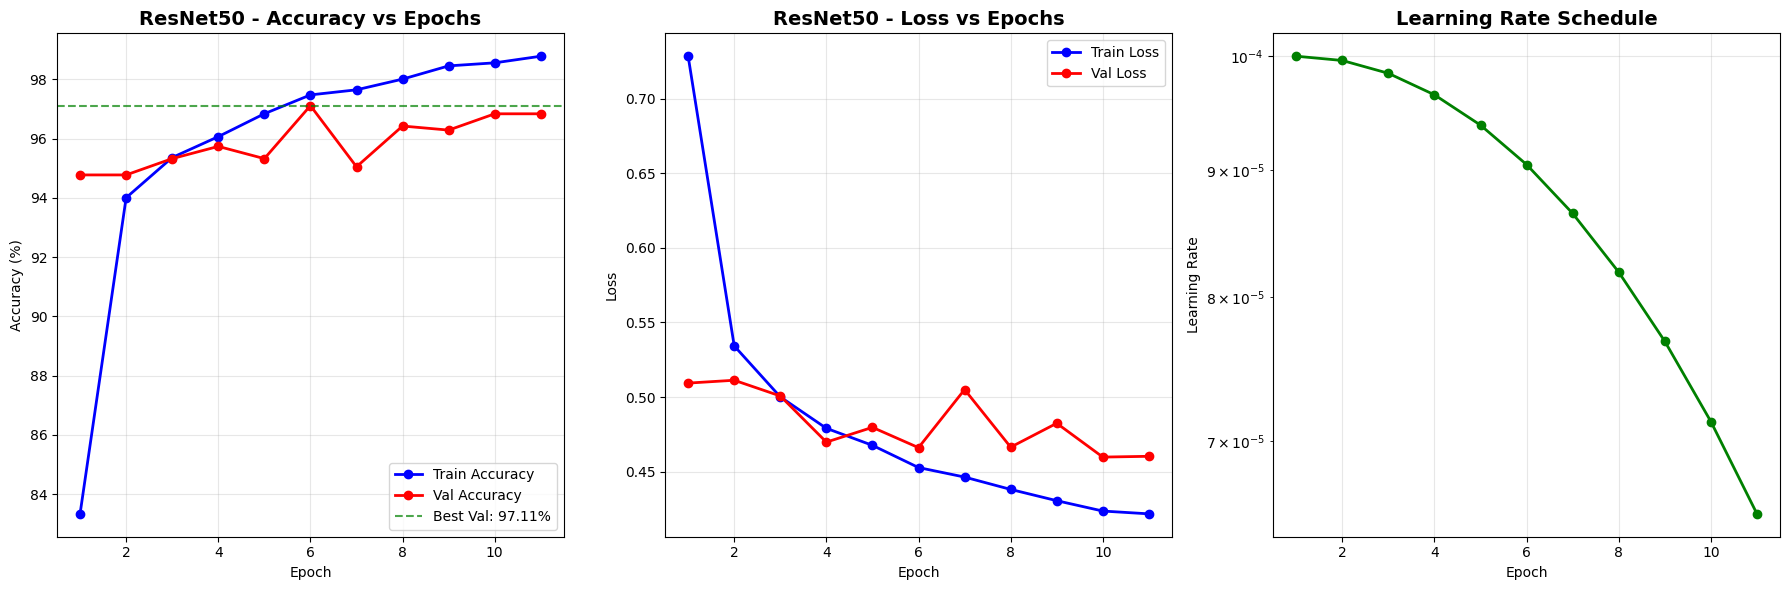

In [6]:
# Model setup
print(" Loading ResNet50 model...")
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Training loop
num_epochs = 25  
best_val_acc = 0.0
patience = 5
patience_counter = 0
# Loss
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # helps generalization

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)  # works for CNNs and Transformers

# Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)  # simple, effective


# Tracking history
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
learning_rates = []


print("Starting training...")
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    print(f"Learning Rate: {current_lr:.6f}")
    
    # Training
    model.train()
    running_loss = 0.0
    correct_train = total_train = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        if batch_idx % 50 == 0:
            print(f'  Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

    train_acc = correct_train / total_train
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    correct = total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc*100:.2f}%")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")
    
    # Save best model and early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_ResNet50_driver_behavior.pth')
        print(f"✓ New best validation accuracy: {best_val_acc*100:.2f}%")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement")
            break
    
    scheduler.step()

# Load best model for final evaluation
model.load_state_dict(torch.load('best_ResNet50_driver_behavior.pth'))

# Final test evaluation
print("\nEvaluating on test set...")
model.eval()
correct = total = 0
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        # Per-class accuracy
        c = (predicted == labels).squeeze()
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

test_acc = correct / total * 100
print(f"\nOverall Test Accuracy: {test_acc:.2f}%")

# Per-class accuracy
print("\nPer-class Test Accuracy:")
for i in range(num_classes):
    if class_total[i] > 0:
        acc = 100 * class_correct[i] / class_total[i]
        print(f"{full_dataset.classes[i]}: {acc:.2f}% ({int(class_correct[i])}/{int(class_total[i])})")

# Enhanced plotting
epochs_completed = range(1, len(train_losses) + 1)
plt.figure(figsize=(18, 6))

# Accuracy Plot
plt.subplot(1, 3, 1)
plt.plot(epochs_completed, [acc*100 for acc in train_accuracies], 'o-', label='Train Accuracy', color='blue', linewidth=2)
plt.plot(epochs_completed, [acc*100 for acc in val_accuracies], 'o-', label='Val Accuracy', color='red', linewidth=2)
plt.axhline(y=best_val_acc*100, color='green', linestyle='--', alpha=0.7, label=f'Best Val: {best_val_acc*100:.2f}%')
plt.title('ResNet50 - Accuracy vs Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss Plot
plt.subplot(1, 3, 2)
plt.plot(epochs_completed, train_losses, 'o-', label='Train Loss', color='blue', linewidth=2)
plt.plot(epochs_completed, val_losses, 'o-', label='Val Loss', color='red', linewidth=2)
plt.title('ResNet50 - Loss vs Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Learning Rate Plot
plt.subplot(1, 3, 3)
plt.plot(epochs_completed, learning_rates[:len(epochs_completed)], 'o-', color='green', linewidth=2)
plt.title('Learning Rate Schedule', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

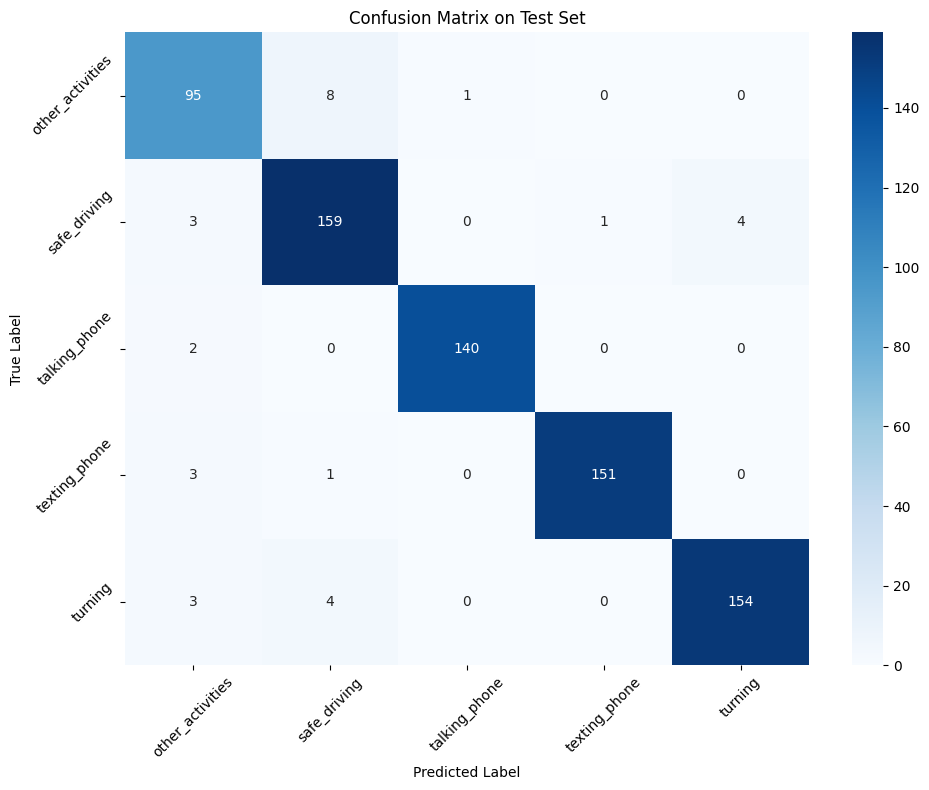

In [7]:
# Collect all predictions and labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = full_dataset.classes

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# Final test evaluation with AUC and inference time
model.eval()
correct = total = 0
all_labels = []
all_probs = []
inference_times = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        start_time = time.time()
        outputs = model(images)
        end_time = time.time()

        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        inference_times.append(end_time - start_time)
        all_labels.append(labels.cpu())
        all_probs.append(probs.cpu())

test_acc = correct / total * 100
avg_infer_time = np.mean(inference_times)

# Concatenate tensors
all_labels = torch.cat(all_labels).numpy()
all_probs = torch.cat(all_probs).numpy()

# AUC score
try:
    auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
    print(f"AUC (multi-class OVR): {auc:.4f}")
except Exception as e:
    print("AUC calculation failed:", e)

print(f"Final Test Accuracy: {test_acc:.2f}%")
print(f"Average Inference Time per Batch: {avg_infer_time:.4f} seconds")
print(f"Average Inference Time per Sample: {avg_infer_time / batch_size:.6f} seconds")

AUC (multi-class OVR): 0.9957
Final Test Accuracy: 95.88%
Average Inference Time per Batch: 0.0107 seconds
Average Inference Time per Sample: 0.000334 seconds
